# Exploratory Data Analysis: ANZ Synthesized 3-month Transactional Dataset


## Step 0: Loading the dataset

In [2]:
# These are the necessary Python libraries to perform EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [3]:
# referencing the csv file as file
file = 'DATA/original-data.csv'
# Read file and parse timestamp as the index
df = pd.read_csv(file, index_col=0, parse_dates=True)

In [4]:
# confirmation of existing columns of file on load
df.columns


Index(['date', 'status', 'age', 'gender', 'txn_description', 'balance',
       'amount', 'card_present_cat', 'long', 'lat', 'geometry', 'merch_suburb',
       'merch_state', 'merch_geometry', 'merch_long', 'merch_lat'],
      dtype='object')

In [5]:
# confirmation of data types prior to conversion
df.dtypes

date                 object
status               object
age                   int64
gender               object
txn_description      object
balance             float64
amount              float64
card_present_cat    float64
long                float64
lat                 float64
geometry             object
merch_suburb         object
merch_state          object
merch_geometry       object
merch_long          float64
merch_lat           float64
dtype: object

## Step 1: Data Wrangling

* It is important that data can be parsed for a variety of downstream purposes. 
* The data below will be converted into the appropriate data types for assuring data quality and usefulness.
* The guidelines for the conversion are laid out in the data dictionary. Please refer to readme.md file

### Dealing with missing values

In [6]:
# display all missing values
df.isna().sum()

date                   0
status                 0
age                    0
gender                 0
txn_description        0
balance                0
amount                 0
card_present_cat    4326
long                   0
lat                    0
geometry               0
merch_suburb        4326
merch_state         4326
merch_geometry      4326
merch_long             0
merch_lat              0
dtype: int64

* All the columns missing values such as card_present_cat, merch_suburb, merch_state and merch geometry as displayed above all have trasitive dependencies with status, such that the value posted determines a null value for these columns. Several options can be considered:
  * Removing the rows: This task prioritizes a time series analysis for the transactions so removing the rows will not be preferable as that would remove valuable data we want to keep
  * Filling missing values with 0: This is a good choice given that all of the columns with missing values would not be affected by this change. This is because these columns a trasitively dependent on status, therefore not causing any conflicts for the analysis. Card_present_cat field will also not be affected by the insertion of more 0s as it is still treated as False when converted to Boolean, which is done in the following code executions.


In [7]:
# fill missing columns with 0
df.fillna(0, inplace=True)

In [8]:
# check if all missing values have been replaced
df.isna().sum()

date                0
status              0
age                 0
gender              0
txn_description     0
balance             0
amount              0
card_present_cat    0
long                0
lat                 0
geometry            0
merch_suburb        0
merch_state         0
merch_geometry      0
merch_long          0
merch_lat           0
dtype: int64

### Data type conversion

In [9]:
# convert status into categorical data type
s = pd.CategoricalDtype(categories=['authorized', 'posted'], ordered=True)
df.status = df.status.astype(s)

In [10]:
# convert card_present_cat into category data type with values 1 and 0
cpc = pd.CategoricalDtype(categories=[1, 0], ordered=True)
df.card_present_cat = df.card_present_cat.astype(cpc)

In [11]:
# create new Boolean column named card_present_bool
b = pd.BooleanDtype()
df['card_present_bool'] = df.card_present_cat.astype(b)

In [12]:
# convert gender into category data type with values M and F
g = pd.CategoricalDtype(categories=['M', 'F'], ordered=True)
df.gender = df.gender.astype(g)

In [13]:
# convert age into int32 data type
df.age = df.age.astype('int32')

In [14]:
# convert txn_description field into category data type
td = pd.CategoricalDtype(categories=['POS','SALES-POS','PAYMENT','INTER BANK','PAY/SALARY','PHONE BANK'], ordered=True)
df.txn_description = df.txn_description.astype(td)

In [15]:
# check all data types have been converted correctly
df.dtypes

date                   object
status               category
age                     int32
gender               category
txn_description      category
balance               float64
amount                float64
card_present_cat     category
long                  float64
lat                   float64
geometry               object
merch_suburb           object
merch_state            object
merch_geometry         object
merch_long            float64
merch_lat             float64
card_present_bool     boolean
dtype: object

## Step 2: Overview

a. What is the average transaction amount?

* In order to measure the central tendency, some descriptive statistics should help to determine the best metric

In [16]:
# Generate summary statistics for amount
df.amount.describe()

count    12043.000000
mean       187.933588
std        592.599934
min          0.100000
25%         16.000000
50%         29.000000
75%         53.655000
max       8835.980000
Name: amount, dtype: float64

* The above summary suggests that there is a heavy amount of positive skew for this distrbitution. It is also quite excessively leptokurtic on a normal scale, meaning that a log transformation should probably be applied to smooth the distribution.

In [17]:
# check for skew on untransformed amount data
df.amount.skew()

5.356266394770427

In [18]:
# transform amount series into a log scale
amount_log = np.log(df.amount)
amount_log.skew()

1.4091072595935499

* The log transformation managed to reduce skewness from 5.356266394770427 to 1.4091072595935499. As skewness is not 0, the mean is not a very good measure of central tendency.
* Plotting a histogram with seaborn can give a good visualisation of the amounts.

<AxesSubplot:xlabel='amount', ylabel='Count'>

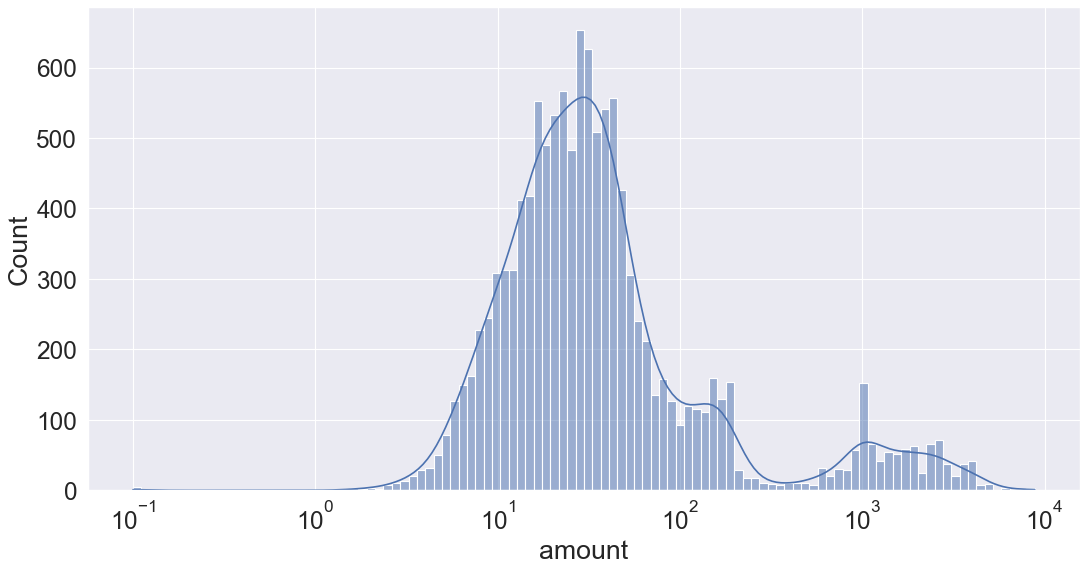

In [19]:
# Make a figure using matplotlib
fig = plt.figure(figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')
# set font size in sns
sns.set(font_scale=2)
# plot a histogram using an adjusted logscale and probability density curve
sns.histplot(data=df, x='amount', log_scale=True, kde=True)

In [20]:
df.amount.mean()

187.93358797641767

In [21]:
df.amount.median()

29.0

In [22]:
df.amount.mode()

0    33.0
dtype: float64

* Since there is a large discrepency between the mean and median, as well as mean and mode. The median seems to be quite an accurate measure of central tendency
* Hence the average transaction amount seems to be **$29.00AUD**

b. How many transactions do customers make each month, on average?

In [62]:
m = df.index.month_name()


Index(['August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August',
       ...
       'October', 'October', 'October', 'October', 'October', 'October',
       'October', 'October', 'October', 'October'],
      dtype='object', name='timestamp', length=12043)

<AxesSubplot:>

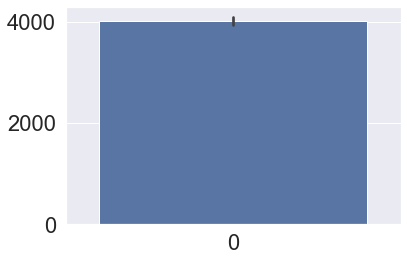

In [60]:
# Make barplot for transactions per month
sns.barplot(data=m)

In [25]:
avg_trans_per_month = trans_per_month.mean()
avg_trans_per_month

4014.3333333333335

In [33]:
df.index.year

Int64Index([2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
            ...
            2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],
           dtype='int64', name='timestamp', length=12043)

In [146]:
df.index.time

array([datetime.time(1, 1, 15), datetime.time(1, 13, 45),
       datetime.time(1, 26, 15), ..., datetime.time(23, 34, 25),
       datetime.time(23, 47, 5), datetime.time(23, 59, 44)], dtype=object)

In [156]:
df.index.strftime('%m/%d/%Y')

Index(['08/01/2018', '08/01/2018', '08/01/2018', '08/01/2018', '08/01/2018',
       '08/01/2018', '08/01/2018', '08/01/2018', '08/01/2018', '08/01/2018',
       ...
       '10/31/2018', '10/31/2018', '10/31/2018', '10/31/2018', '10/31/2018',
       '10/31/2018', '10/31/2018', '10/31/2018', '10/31/2018', '10/31/2018'],
      dtype='object', name='timestamp', length=12043)

In [157]:
df.index.strftime('%H:%M')

Index(['01:01', '01:13', '01:26', '01:38', '01:51', '02:00', '02:23', '04:11',
       '04:40', '06:00',
       ...
       '22:22', '22:51', '23:00', '23:00', '23:00', '23:09', '23:21', '23:34',
       '23:47', '23:59'],
      dtype='object', name='timestamp', length=12043)

In [152]:
df.index.day_name()

Index(['Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday',
       'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday',
       ...
       'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday',
       'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Wednesday'],
      dtype='object', name='timestamp', length=12043)

In [165]:
df.index.to_period('M')

PeriodIndex(['2018-08', '2018-08', '2018-08', '2018-08', '2018-08', '2018-08',
             '2018-08', '2018-08', '2018-08', '2018-08',
             ...
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10'],
            dtype='period[M]', name='timestamp', length=12043, freq='M')

Insight: EFTPOS transactions top the list when it comes to most transactions conducted.

<AxesSubplot:>

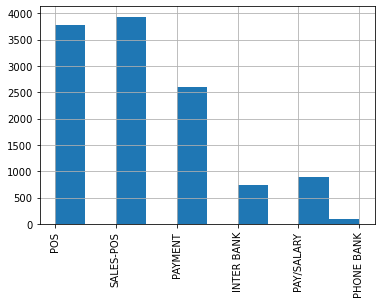

In [180]:
df.txn_description.hist(xrot=90)

Insight: Majority of the transactions are conducted by ages 30 and below

<AxesSubplot:>

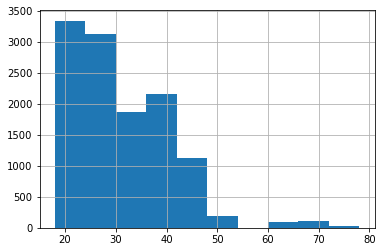

In [172]:
df.age.hist()

In [174]:
time_group = df.groupby('timestamp').sum()

Q: What time of day is the most active for transaction activity? Around 11:06 AM till 16:40 PM

<AxesSubplot:xlabel='timestamp'>

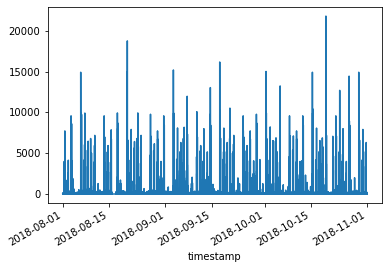

In [175]:
time_group['amount'].plot()

Plot for balance versus time

<AxesSubplot:xlabel='time', ylabel='balance'>

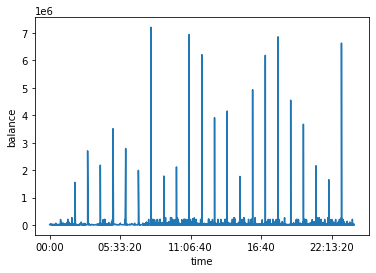

In [73]:
time_group['balance'].plot(ylabel= 'balance')

The plot below shows that overall, people approximating the age of 40 have a higher balance kept in the bank than most other age groups

<AxesSubplot:xlabel='age', ylabel='balance'>

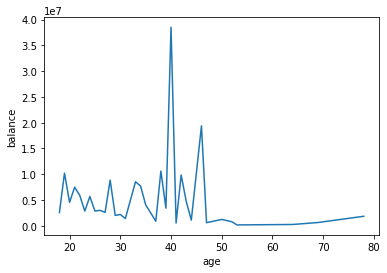

In [32]:
age_group = df.groupby('age').sum()
age_group['balance'].plot(ylabel='balance')


Transactional amounts peak up in ages 20 and 40 years old

<AxesSubplot:xlabel='age', ylabel='amount'>

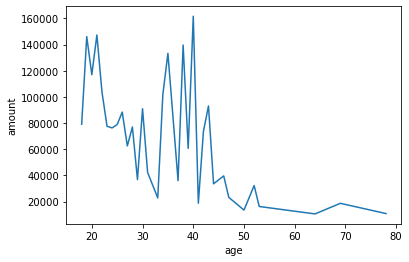

In [73]:
age_group['amount'].plot(ylabel='amount')

In [84]:
# this code sorts the table into authorized vs posted transactions as these columns shows
# high functional dependencies among the columns, which is a violation of 2NF
mask_authorized = df.status == 'authorized'
trans_authorized = df[mask_authorized]
mask_posted = df.status == 'posted'
trans_posted = df[mask_posted]

In [89]:
trans_authorized

,timestamps,date,status,age,gender,txn_description,balance,amount,card_present_flag,long,lat,geometry,merchant_suburb,merchant_state,merchant_long_lat,merch_long,merch_lat,time
0,2018-08-01 01:01:15+00:00,2018-08-01,authorized,26,F,POS,35.39,16.25,1.0,153.41,-27.95,153.41 -27.95,Ashmore,QLD,153.38 -27.99,153.38,-27.99,01:01:15
1,2018-08-01 01:13:45+00:00,2018-08-01,authorized,26,F,SALES-POS,21.20,14.19,0.0,153.41,-27.95,153.41 -27.95,Sydney,NSW,151.21 -33.87,151.21,-33.87,01:13:45
2,2018-08-01 01:26:15+00:00,2018-08-01,authorized,38,M,POS,5.71,6.42,1.0,151.23,-33.94,151.23 -33.94,Sydney,NSW,151.21 -33.87,151.21,-33.87,01:26:15
3,2018-08-01 01:38:45+00:00,2018-08-01,authorized,40,F,SALES-POS,2117.22,40.90,1.0,153.10,-27.66,153.10 -27.66,Buderim,QLD,153.05 -26.68,153.05,-26.68,01:38:45
4,2018-08-01 01:51:15+00:00,2018-08-01,authorized,26,F,SALES-POS,17.95,3.25,1.0,153.41,-27.95,153.41 -27.95,Mermaid Beach,QLD,153.44 -28.06,153.44,-28.06,01:51:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,2018-10-31 23:09:06+00:00,2018-10-31,authorized,30,F,POS,14054.14,9.79,0.0,149.83,-29.47,149.83 -29.47,Ringwood,VIC,145.23 -37.81,145.23,-37.81,23:09:06
12039,2018-10-31 23:21:46+00:00,2018-10-31,authorized,20,M,SALES-POS,9137.79,63.87,1.0,151.22,-33.87,151.22 -33.87,Casula,NSW,150.88 -33.96,150.88,-33.96,23:21:46
12040,2018-10-31 23:34:25+00:00,2018-10-31,authorized,28,M,POS,45394.57,43.96,1.0,151.12,-33.89,151.12 -33.89,Kings Park,NSW,150.92 -33.74,150.92,-33.74,23:34:25
12041,2018-10-31 23:47:05+00:00,2018-10-31,authorized,69,M,SALES-POS,11350.67,30.77,1.0,144.96,-37.76,144.96 -37.76,Oakleigh,VIC,145.09 -37.91,145.09,-37.91,23:47:05


In [105]:
df.card_present_flag = df.card_present_flag.astype('int')

KeyError: "None of [Int64Index([1, 0, 1, 1, 1, 0, 1, 1, 1, 0,\n            ...\n            1, 1, 0, 0, 0, 0, 1, 1, 1, 1],\n           dtype='int64', length=12043)] are in the [columns]"